##Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from keras import layers
from keras.models import Sequential
from sklearn import preprocessing
from sklearn.metrics import classification_report
import os
import warnings
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, Conv2D, MaxPooling1D

##Data EDA

In [ ]:
df=pd.read_csv("train.csv")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,language
0,8.118459,-2.784780,0.414908,0.907955,-7.995316,15.525385,-10.439900,5.001569,-1.512281,-2.719342,2.222301,-5.846886,US
1,-2.374189,-7.297245,7.349022,7.524122,-7.129271,11.292515,-13.649587,4.615975,-0.784158,-4.178449,1.320741,2.530421,ES
2,-0.791621,1.303788,-1.791229,6.227355,-9.602931,8.602848,-7.727415,6.436677,-0.055187,0.486530,1.698110,-1.761528,FR
3,-3.177167,-4.239308,1.106003,10.937736,-8.870120,6.314209,-9.932148,0.379124,-1.273991,-0.336232,5.219751,-5.748222,US
4,10.978152,1.643641,6.195087,1.265713,5.735026,9.046351,-7.799853,0.789758,-2.697877,-9.736504,4.329233,-4.248319,UK


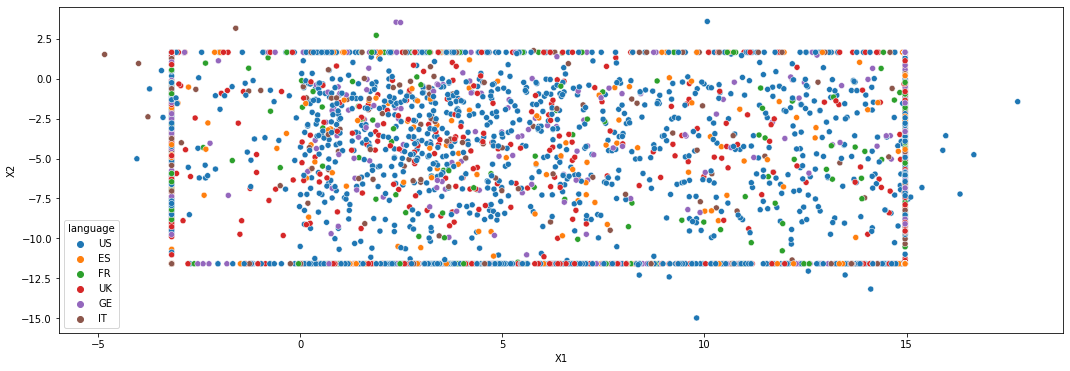

In [ ]:
plt.figure(figsize=(18,6))
sns.scatterplot(x="X1",y="X2",hue='language',data=df)
plt.show()

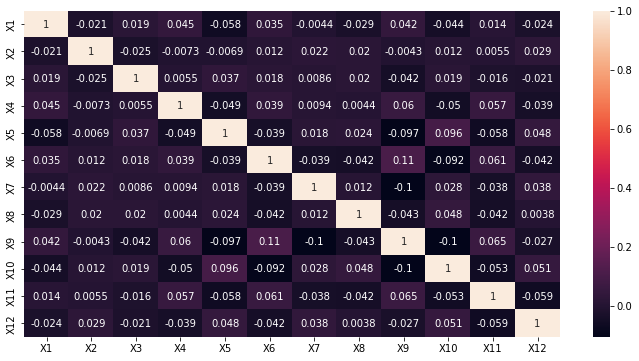

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),data=df, annot=True)
plt.show()

In [ ]:
df=df.drop(df[df['language']=='US'].sample(frac=.4).index)
df['language'].value_counts()

US    1160
UK     647
GE     414
ES     339
IT     327
FR     300
Name: language, dtype: int64

##Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(df.drop(columns=['language'],axis=1),
                                                  df['language'],test_size=0.2,shuffle=True, random_state=42)

In [ ]:
x_train[150:160]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
1329,10.689768,-11.581520,3.454817,-1.744327,-10.328041,11.624716,-11.658593,7.455915,1.898054,-7.068899,6.942571,2.530421
2253,14.964859,-11.581520,2.964347,3.428276,-9.686027,14.590714,-13.649587,10.858532,-7.444550,-3.398222,6.075656,-3.749431
582,14.964859,-8.741585,-2.222923,13.944107,-9.602788,15.525385,-11.933918,8.790536,-0.013961,-5.138249,1.407235,-7.948384
1694,4.342441,-6.905375,-2.222923,9.357423,-6.669570,14.114546,-8.257076,4.387507,0.379779,-0.303544,3.403961,-0.030031
1911,5.981695,-7.284295,-0.751734,8.340719,-7.557755,2.673641,-13.649587,4.159683,-0.097615,-1.787620,6.606773,-5.525798
2891,14.964859,-2.194695,-2.222923,13.944107,-6.956201,15.525385,-8.190320,0.730842,2.187525,-6.860840,0.153843,-4.119669
2187,8.832310,-1.560250,-0.779165,5.791806,-9.747724,10.741270,-7.475309,7.081552,-2.180106,-4.058377,4.304088,-7.824542
1552,14.964859,-11.581520,2.571470,2.120876,-0.900682,10.136657,-12.068159,4.115187,-0.701057,-4.584795,1.115809,-1.923852
1386,7.089313,-11.581520,0.430922,8.180945,-8.446003,1.591965,-4.501308,4.679665,1.475776,-3.963296,1.928643,-6.065879
2243,14.964859,-2.457431,5.142436,-1.744327,-4.045826,15.525385,-10.398626,3.711989,3.431620,-6.351752,2.886762,-5.707885


make the dataset keras compatible

In [ ]:
import pickle
import tensorflow as tf
import keras
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

#one-hot encode the target
lb=preprocessing.LabelEncoder()
y_train=tf.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test=tf.keras.utils.to_categorical(lb.fit_transform(y_test))

print(x_train.shape)
print(x_test.shape)
print(lb.classes_)

#라벨(국가)만 골라서 파일 하나 만들기
filename='labels'
outfile=open(filename,'wb')
pickle.dump(lb, outfile)
outfile.close()

(2549, 12)
(638, 12)
['ES' 'FR' 'GE' 'IT' 'UK' 'US']


In [ ]:
x_train=np.expand_dims(x_train, axis=2)
x_test=np.expand_dims(x_test, axis=2)
x_train.shape

(2549, 12, 1)

##Modeling
문제1: 오버피팅(training accuracy는 0.9인데 val_accuracy는 0.2)

해결방법: 
- 드롭아웃 비율 높이기
- 모델 복잡도 줄이기
- 데이터셋 늘리기
---
문제2: 언더피팅(학습이 잘 되지 않은 상황)

해결방법:
- 모델 복잡도 늘리기
- 에폭 늘리기
---
최적화: 
- optimizer 바꿔보기
- lr 바꿔보기
- 가중치 초기화...?


In [ ]:
#new model
from keras import layers
'''model = Sequential()
model.add(Conv1D(128, 8, padding='same', input_shape=(x_train.shape[1],1), activation='relu', kernel_initializer="he_normal"))

model.add(Conv1D(64, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8))
model.add(Dropout(0.2))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())'''
model=Sequential()
model.add(Dense(64, input_shape=(x_train.shape[1],)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(16))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 64)                832       
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_50 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_62 (Activation)  (None, 64)                0         
                                                                 
 dense_63 (Dense)            (None, 64)                4160      
                                                                 
 dropout_51 (Dropout)        (None, 64)                0         
                                                     

In [ ]:
#opt=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
classifier=model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), verbose=2)

Epoch 1/500
80/80 - 2s - loss: 2.2844 - accuracy: 0.1181 - val_loss: 1.8706 - val_accuracy: 0.1301 - 2s/epoch - 30ms/step
Epoch 2/500
80/80 - 0s - loss: 2.2342 - accuracy: 0.1330 - val_loss: 1.9071 - val_accuracy: 0.1191 - 293ms/epoch - 4ms/step
Epoch 3/500
80/80 - 0s - loss: 2.1587 - accuracy: 0.1495 - val_loss: 1.9134 - val_accuracy: 0.1191 - 301ms/epoch - 4ms/step
Epoch 4/500
80/80 - 0s - loss: 2.1029 - accuracy: 0.1503 - val_loss: 1.8977 - val_accuracy: 0.1301 - 289ms/epoch - 4ms/step
Epoch 5/500
80/80 - 0s - loss: 2.0987 - accuracy: 0.1608 - val_loss: 1.8756 - val_accuracy: 0.1379 - 289ms/epoch - 4ms/step
Epoch 6/500
80/80 - 0s - loss: 2.0450 - accuracy: 0.1510 - val_loss: 1.8570 - val_accuracy: 0.1505 - 260ms/epoch - 3ms/step
Epoch 7/500
80/80 - 0s - loss: 2.0103 - accuracy: 0.1746 - val_loss: 1.8383 - val_accuracy: 0.1693 - 260ms/epoch - 3ms/step
Epoch 8/500
80/80 - 0s - loss: 1.9972 - accuracy: 0.1714 - val_loss: 1.8205 - val_accuracy: 0.1850 - 262ms/epoch - 3ms/step
Epoch 9/50

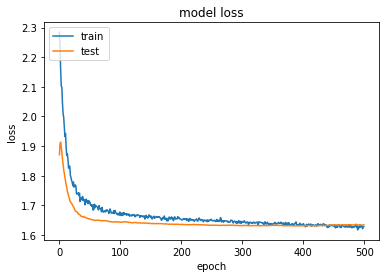

In [ ]:
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

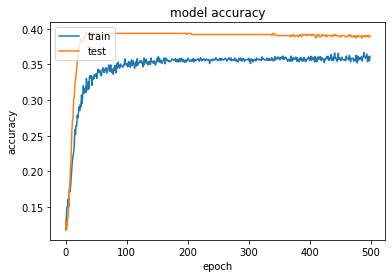

In [ ]:
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

##Model serialisation

In [ ]:
#save model and weights
model_name="Speech.h1"
save_dir=os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
model_path=os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s '%model_path)

#save the model to disk
model_json=model.to_json()
with open("model_json_aug.json", "w") as json_file:
  json_file.write(model_json)

INFO:tensorflow:Assets written to: /content/saved_models/Speech.h1/assets
Save model and weights at /content/saved_models/Speech.h1 
